In [57]:
%reset-f
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from pandas.io import wb
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%autoreload
from res_ind_lib import *
import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)

from sorted_nicely import *

In [59]:

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 10)
pd.set_option('display.max_rows', 500)


# Data

###  from the world bank

In [60]:
nb_weeks = (time.time()-os.stat("wb_data.csv").st_mtime )/(3600*24*7)
if nb_weeks>20: 
    warnings.warn("World bank data are "+str(int(nb_weeks))+" weeks old. You may want to download them again.")
df=pd.read_csv("wb_data.csv").set_index("country")
df.dropna().shape

(73, 12)

In [61]:
#Income gorups for countries and HIPC status
groups = pd.read_csv("income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups= groups[["Code","Region","Income group","Lending category","Other"]]
groups.dropna(axis=0,how="all",inplace=True);
groups.rename(columns={"Other":"HIPC"},inplace=True)
groups['HIPC'].fillna('norm',inplace=True)
groups["Lending category"].replace("..","",inplace=True)

df["iso3"]=groups["Code"]


In [62]:
def names_to_wb_name(df_in,any_name_to_iso3,iso3_to_unique_name,common_name="iso3",end_name="country"):
    """Matches arbitrary country names from a dataset to world bank country names thru iso3 codes"""
    
    df=pd.DataFrame(df_in)
    
    index_name=df.index.name
    
    df[common_name]=any_name_to_iso3[common_name]
    
    #warns and prints if some countries are not recognized
    cond = df[common_name].isnull()
    if cond.sum()>0:
        warnings.warn("Unrecognized countries in 1st argument 'df':"+", ".join((df.index[cond].values)))
        warnings.warn("Correct 'df' or add lines to 2nd argument 'any_name_to_iso3'")
    
    df=df.dropna()
    
    #warning if missing
    df =df.reset_index().set_index(common_name)
    df[end_name]=iso3_to_unique_name
    cond = df[end_name].isnull()
    if cond.sum()>0:
        warnings.warn("this countries appear to be missing from 3rd argument 'iso3_to_unique_name':"+", ".join((df.index[cond])))

           
    #return df with original indexing
    return df.dropna().set_index(index_name)

### Definitions

In [63]:
# share of poor individuals, we chose the bottom 20
ph=df["pov_head"]=0.2 

### HFA

gets hfa data

In [64]:
# READ THE LAST HFA DATA
hfa_newest =   pd.read_csv("HFA_all_2011_2013.csv").rename(columns={"ISO 3":"iso3","Country name":"country"}).set_index("country")

# READ THE PREVIOUS HFA DATA
hfa_previous = pd.read_csv("HFA_all_2009_2011.csv").rename(columns={"ISO 3":"iso3","Country name":"country"}).set_index("country")

#most recent values... if no 2011-2013 reporting, we use 2009-2011
hfa=hfa_newest.fillna(hfa_previous)

# access to early warning = priority for action 2, indicator 3 of the HFA
hfa["shew"]=1/5*hfa["P2-C3"] # between zero and 1. 

# ability to scale up = average of priority for action 5 of the HFA
#hfa["prepare_scaleup_old"]=(hfa["P5-C1"]+hfa["P5-C2"]+hfa["P5-C4"])/3/5 # between zero and 1
hfa["prepare_scaleup"]=(hfa["P4-C2"]+hfa["P5-C2"]+hfa["P4-C5"])/3/5 # between zero and 1
hfa["finance_pre"] = hfa["P5-C3"]/5 #betwenn 0 and 1


matches names with wb names

In [65]:
#this table matches country names rendered in several ways to their actual iso2 and iso3 codes
any_name_to_iso3 =pd.read_csv("names_to_iso.csv").set_index("country")
#this tables has WB country names and iso3 countries
iso3_to_unique_name = pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")

#matches names in HFA to  names
df[["shew","prepare_scaleup","finance_pre"]]= names_to_wb_name(hfa[["shew","prepare_scaleup","finance_pre"]],any_name_to_iso3,iso3_to_unique_name) 

# Assumes that no HFA reporting means no preparation
df[["shew","prepare_scaleup","finance_pre"]] = df[["shew","prepare_scaleup","finance_pre"]].fillna(0)

### EUsilc and other countries

In [66]:
silc = pd.read_csv("social_ratios.csv")
#EU cuntry code to iso2 
silc["iso2"]=silc["cc"].replace({"EL":"GR","UK":"GB"}) #Greece and UK
silc.set_index("iso2",inplace=True)

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("names_to_iso.csv")[["iso2","iso3"]].drop_duplicates().set_index("iso3") #the tables has more lines than countries to account for several ways of writing country names

#iso2 to WB 
iso2_iso3["country"]=iso3_to_wb["country"]
iso2_country=iso2_iso3.reset_index().set_index("iso2")

#indexes this data by WB country
silc["country"]=iso2_country["country"]
silc.set_index("country",inplace=True)
#silc.drop_duplicates(inplace=True)

#Monitoring differences between SILC and ASPIRE
#hop=df.ix[silc.index,["social_p","social_r"]].dropna().rename(columns=dict(social_p = "s_p_aspire", social_r="s_r_aspire"))
#hop[["sp_silc","sr_silc"]]= silc.ix[hop.index,["social_p","social_r"]]
#plt.scatter(x=hop.sp_silc,y=hop.s_p_aspire), plt.scatter(x=hop.sr_silc,y=hop.s_r_aspire,c="red")

df.ix[silc.index,["social_p","social_r"]]=silc[["social_p","social_r"]]

### Country Ratings

In [67]:
#Reads the data and check its not too old
the_credit_rating_file ="cred_rat.csv"
nb_weeks = (time.time()-os.stat(the_credit_rating_file).st_mtime )/(3600*24*7)
if nb_weeks>3: 
    warnings.warn("Credit ratings are "+str(int(nb_weeks))+" weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating")
ratings_raw  =pd.read_csv(the_credit_rating_file,dtype="str").dropna(how="all")
ratings_raw=ratings_raw.rename(columns={"Unnamed: 0": "country_in_ratings"}).set_index("country_in_ratings")[["S&P","Moody's","Fitch"]]
ratings_raw.rename(index=str.strip,inplace=True)

#this table matches country names rendered in several ways to their actual iso2 and iso3 codes
names_to_iso =pd.read_csv("names_to_iso.csv").set_index("country")

#this tables has WB country names and iso3 countries
iso_country = pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")

ratings_raw =  names_to_wb_name(ratings_raw,names_to_iso,iso_country)
#ratings_raw=ratings_raw.reset_index().set_index("country")

def mystriper(string):
    """strip blanks and converts everythng to lower case"""
    if type(string)==str:
        return str.strip(string).lower()
    else:
        return string
        
#to lower case and strips blanks
ratings_raw=ratings_raw.applymap(mystriper)    

#Transforms ratings letters into 1-100 numbers
rat_disc = pd.read_csv("cred_rat_dict.csv")
ratings=ratings_raw
ratings["S&P"].replace(rat_disc["s&p"].values,rat_disc["s&p_score"].values,inplace=True)
ratings["Moody's"].replace(rat_disc["moodys"].values,rat_disc["moodys_score"].values,inplace=True)
ratings["Fitch"].replace(rat_disc["fitch"].values,rat_disc["fitch_score"].values,inplace=True)
df["rating"]=ratings.mean(axis=1)/100

df["rating"].fillna(0,inplace=True)  #assumes no rating is bad rating


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:5: UserWarning: Credit ratings are 14 weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating


### Capital data

In [68]:
#data arranged from Penn tables
k_data=pd.read_csv("capital_data.csv")[["code","cgdpo","ck"]].replace({"ROM":"ROU","ZAR":"COD"}).rename(columns={"cgdpo":"prod_from_k","ck":"k"})#Zair is congo

#matches names in the dataset with world bank country names
iso_country = pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")
k_data.set_index("code",inplace=True)
k_data["country"]=iso_country["country"]
cond = k_data["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(k_data.index[cond].values))
k_data=k_data.reset_index().set_index("country")

# average productivity of capital
df["avg_prod_k"]=k_data["prod_from_k"]/k_data["k"]


###Hazard (protection)

In [69]:
#assumed a function of the income group
protection_assumptions = pd.read_csv("protection_level_assumptions.csv").set_index("Income group")
df["protection"]=groups["Income group"].replace(protection_assumptions["protection"])

### Exposure (population in flood-prone areas)

In [70]:
#Esposure data 
expo = pd.read_csv("exposure_econ_return_period.csv",index_col="country");

"""pd.read_csv("exposure_econ_return_period_FALSE.csv)",
                usecols=["ISO","people_affected_RP10flood_percent"],
                index_col="ISO")


expo["country"]=iso3_to_wb_name["country"]
"""

df["faref"]=df["fa"]=expo["100"]

#Exposure bias
pe=df["peref"] =df["pe"]=.2

fa_ratios = expo.div(df["fa"],axis=0).dropna()

fa_ratios["2"]=fa_ratios["5"] #assumes flat exposure before 5 yr rp

#print(fa_ratios.columns)
#fa_ratios[(fa_ratios==0)]=1e-6 #tiny exposure where no exposure

fa_ratios.columns=map(lambda x:"fa_ratio_"+x,fa_ratios.columns)
fa_ratios = fa_ratios.reindex_axis(sorted_nicely(fa_ratios.columns), axis=1)

df[fa_ratios.columns]=fa_ratios

In [71]:
iso3_to_wb_name = pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")


### Vulnerability

In [72]:
#Reads data from pager
pager=pd.read_csv("pager_vulnerabilities.csv",
                  usecols=["ISO-3digit","R_1","R_2","R_3","VV_1","VV_2","VV_3","Country Name"],
                  index_col="ISO-3digit")

#indexes pager data by country        
pager["country"]=iso3_to_wb_name["country"]
cond = pager["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(pager.index[cond].values)+".\nThese are: "+" , ".join(pager.ix[cond,"Country Name"].values) )
pager["country"]=iso3_to_wb_name["country"]
hop=pager.dropna().reset_index().set_index("country")

#sorts vulnerabilites according to income
share =hop[["R_1","R_2","R_3"]]
damrat=hop[["VV_1","VV_2","VV_3"]]

damrat.columns=["R_1","R_2","R_3"]
p=(share.cumsum(axis=1)-.20).clip(lower=0)
poor=(share-p).clip(lower=0)


vp=(poor*damrat).sum(axis=1)/poor.sum(axis=1)
rich=share-poor

vr=(rich*damrat).sum(axis=1)/rich.sum(axis=1)


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: UserWarning: this countries appear to be missing from iso3_to_wb_name.csv: ALA , ATA , BES , BVT , IOT , CXR , CCK , FLK , GUF , ATF , GIB , GLP , GGY , HMD , VAT , JEY , MTQ , MYT , MSR , NFK , PCN , REU , BLM , SHN , SPM , SGS , SJM , TKL , UMI , WLF , ESH.
These are: Aland Islands , Antarctica , Bonaire , Bouvet Island , British Indian Ocean Territory , Christmas Island , the Cocos (Keeling) Islands , the Falkland Islands (Malvinas) , French Guiana , the French Southern Territories , Gibraltar , Guadeloupe , Guernsey , Heard Island and McDonald Islands , the Holy See (Vatican City State) , Jersey , Martinique , Mayotte , Montserrat , Norfolk Island , Pitcairn , Reunion , Saint Barthelemy , Saint Helena , Saint Pierre and Miquelon , South Georgia and the South Sandwich Islands , Svalbard and Jan Mayen , Tokelau , the United States Minor Outlying Islands , Wallis and Futuna , Western Sahara


In [73]:
#Expresses vulnerability as total and bias

fa=df["fa"]
pe=df["peref"] =df["pe"]
fap=fa*(1+pe)
far=(fa-ph*fap)/(1-ph)

df["share1_ref"]=df["share1"]
cp=   df["share1"] /.2*df["gdp_pc_pp"]
cr=(1-df["share1"])/.8*df["gdp_pc_pp"]

df["v"]  = (ph*vp*cp*fap + (1-ph)*vr*cr*far)/(ph*cp*fap + (1-ph)*cr*far)
df["pv"] =  vp/df.v-1

#vulnerability of diversified (shared) capital
df["v_s"]=vr



### Homogenity of losses

In [74]:
#resds loss distribution in mumbai
hop=pd.read_csv("losses_distribution_mumbai.csv",index_col=0)["losses/asset_cost"]
# standard deviation of the underlying normal distribution
s = np.log(hop).std() 

df["H"]= np.exp (-s**2/2)


## Report missing data for the national studies

In [75]:
def write_missing_data(s):
    which = s[s.isnull()].index.values
    return ", ".join(which)

def count_missing_data(s):
    return s.isnull().sum()

report = pd.DataFrame()

report["nb_missing"]=df.apply(count_missing_data,axis=1)  
report["missing_data"]=df.apply(write_missing_data,axis=1)

report  = report.ix[report["nb_missing"]>0,:]
report.sort(columns="nb_missing",inplace=True)
report.to_csv("missing_data_report.csv")

report.head()

,nb_missing,missing_data
country,,
Togo,1,social_p
Djibouti,1,unemp
Nicaragua,1,avg_prod_k
Iraq,1,plgp
Russian Federation,2,"social_p, social_r"


## manual parametrization

In [76]:
# no ripple effects
df["alpha"] =1 

#Reconstruction time
df["T_rebuild_K"] = 3
df["T_rebuild_L"] = 40

# how much early warning reduces vulnerability
df["pi"] = 0.2

#income elasticity
df["income_elast"] = 1.5

# Computes and saves national resilience

Central cases

In [77]:
df["original_country"]=df.index;
#saves orginal dataframe before adding columns with results
df.drop("iso3", axis=1).to_csv("df_original.csv")
df.ix["France"];

In [78]:
df_with_results=compute_resiliences(df.dropna())
print("nb countries with all data :"+str(df.dropna().shape[0]))
print("nb countries with all data and results :"+str(df_with_results["resilience"].dropna().shape[0]))
df_with_results.to_csv("df.csv")


nb countries with all data :90
nb countries with all data and results :90


In [79]:
#magic redistribution
df_share1 = compute_resiliences( df.dropna().assign(share1=df.share1+1/100) )

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-9
wb=df_share1.total_equivalent_cost.sum()*1e-9

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-9
kb = (df_share1.dKtot/df_share1.protection).sum()*1e-9

print(" Increasing the share of income of the bottom quintile by 1 percent in the 90 countries \
would increase asset losses from USD {ka:0.0f} to {kb:0.0f} billions per year \
      (+{XX:.1f} percent), but reduce welfare losses by {YY:.2} percent".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=100*(wa-wb)/wa)
     )

 Increasing the share of income of the bottom quintile by 1 percent in the 90 countries would increase asset losses from USD 102 to 103 billions per year       (+1.0 percent), but reduce welfare losses by 2.6 percent


Basic reporting

In [80]:
#Some stats
a=df_with_results.resilience;
a.min()*100,a.mean()*100,a.max()*100
"Resilience averages {mean:.0%} across our sample, ranging from {min:.0%} to {max:.0%}".format(min=a.min(),mean=a.mean(),max=a.max())

'Resilience averages 58% across our sample, ranging from 25% to 81%'

In [81]:
#Outputs table with main results
to_output = ['gdp_pc_pp', 'pop',"protection","fa","v","resilience","risk"]
a=df_with_results[to_output].copy()
a.loc[:,["fa","v","resilience","risk"]]=100*a[["fa","v","resilience","risk"]]
desc=pd.read_csv("inputs_info.csv").set_index('key')["descriptor"]
a.rename(columns=desc).dropna().to_excel("results.xlsx")


##sensitivity anlysis

In [82]:
def def_ref_values(df):
    df["peref"]=df["pe"]
    df["faref"]=df["fa"]
    df["share1_ref"]=df["share1"]
    vp,vr =unpack_v(df.v,df.pv,df.fa,df.pe,df.pov_head,df.share1)
    df["v_s"] = vr
    return df


In [85]:
country_sens_list=["Malawi","Sweden"]
#reads paramters to be varied
alt_params=pd.read_csv("alt_params.csv")

df_sensit = pd.DataFrame(columns=df.columns)

#for c in country_sens_list:
for c in df.dropna().index: #senstitivity for all countries
    for p in alt_params.index.tolist():
        param = alt_params.ix[p,"param"]
        
        new_value = alt_params.ix[p,"value"]
        if new_value[0] in "/*":
            new_value = str(df.ix[c,param])+new_value         
        new_value = eval(new_value)
        
        d = c+" $({name}={nv:2.0f}\%)$".format(name=alt_params.ix[p,"formated_name"],nv=100*new_value)
        df_sensit.ix[d] = df.ix[c]
        df_sensit.ix[d,param] =new_value
        df_sensit.ix[d,"original_country"]=c
        
        #sets reference values 
        df_sensit =def_ref_values(df_sensit)
        
    
    #special treatment for fa
    df_sensit.ix[d,param] =new_value
    


    for param in ["income_elast"]:
        for new_value in [1, 2]:
            d = c+" $(\eta="+str(new_value)+")$"
            df_sensit.ix[d] = df.ix[c]
            df_sensit.ix[d,param] =new_value
            df_sensit.ix[d,"original_country"]=c

df_sensit.index.name="country"; #after adding indices pandas forgets their 
df_sensit.drop("iso3", axis=1).to_csv("df_sensit_input.csv")
compute_resiliences(df_sensit).to_csv("df_sensit_results.csv")

#Ex post studies

In [86]:
##Reads data
expost_=pd.read_csv("expost_studies.csv",index_col="place")

#fills the altnerative lines with default values
expost = expost_.fillna( value=expost_.ix["Mumbai"],axis=0)

#dummy "ref" dimensions (for the derivatives)
expost = def_ref_values(expost)

#Computes resilience
ep=compute_resiliences(expost,kind="expost")

#Report
ep[expost_.columns]=expost_
ep.to_csv("expost_studies_with_results.csv")
cost_metrics = ["total_equivalent_cost","dKtot"]
ep[cost_metrics]

,total_equivalent_cost,dKtot
place,,
Mumbai,5.300409209e+10,3.455702347e+10
fa_.95,5.035290054e+10,3.282917230e+10
v_.95,5.028305015e+10,3.282917230e+10
double_sigma,4.779834316e+10,3.455702347e+10
rebuild_one_third,5.105727164e+10,3.455702347e+10
double_social,4.836123423e+10,3.455702347e+10
halve_pv,4.984960676e+10,3.455702347e+10
double_banks,5.283438550e+10,3.455702347e+10
share1_ten_percent,5.130791535e+10,3.494304698e+10


###Sensitivity analysis on Mumbai

In [87]:
import pyDOE as doe

In [88]:
pd.read_csv("expost_studies.csv").columns

Index(['place', 'gdp_pc_pp', 'pop', 'share1', 'shew', 'plgp', 'unemp', 'axfin_p', 'axfin_r', 'axhealth', 'social_p', 'social_r', 'iso3', 'pov_head', 'avg_prod_k', 'fa', 'pe', 'H', 'alpha',
       'T_rebuild_K', 'T_rebuild_L', 'pi', 'income_elast', 'v', 'pv', 'sigma_p', 'sigma_r', 'share_nat_income'],
      dtype='object')

In [89]:
uncertain_dims = ['share1', 'shew', 'plgp', 'unemp',
       'axfin_p', 'axfin_r', 'axhealth', 'social_p', 'social_r',
       'pov_head', 'avg_prod_k', 'fa', 'pe', 'H', 'alpha', 'T_rebuild_K',
       'T_rebuild_L', 'pi',  'v', 'pv', 'sigma_p',
       'sigma_r', 'share_nat_income'] 



n=len(uncertain_dims)
var = 1/3

#other_dims = np.setdiff1d(expost.columns,uncertain_dims).tolist()

#mutipliers between 1-var and 1+var
aleas = 1+(2*var * pd.DataFrame(doe.lhs(n,samples=2200,criterion="corr"),columns=uncertain_dims) -var)
aleas

#values that have to change as others
#aleas["sigma_r"]=aleas["sigma_p"]
aleas.head()

new candidate solution found with max,abs corrcoef = 0.8608120501821837
new candidate solution found with max,abs corrcoef = 0.8458905407247883


,share1,shew,plgp,unemp,axfin_p,axfin_r,axhealth,social_p,social_r,pov_head,...,H,alpha,T_rebuild_K,T_rebuild_L,pi,v,pv,sigma_p,sigma_r,share_nat_income
0,1.112460515,1.085372164,0.844196755,1.270403258,1.289143496,1.129564348,0.931782174,0.946598509,1.256693203,1.119133547,...,0.821961857,1.232259776,0.960542342,1.202219319,0.916790197,0.978176979,0.682771303,0.799938650,1.255190781,1.116935262
1,0.733740125,0.976490773,1.039185938,0.676206114,1.041323178,1.308298574,0.832341815,0.783420587,1.207664827,1.157885518,...,0.890036600,0.857875676,1.002367039,1.117464527,0.697355354,1.128868366,0.995412907,1.014758073,0.689980822,0.713324258
2,0.868024751,1.240352416,1.039851752,1.071809226,0.872084805,1.170783960,1.078524402,1.070423871,0.930310210,0.966419891,...,0.742850997,1.203538815,0.990758621,1.126300215,1.314243545,1.204436762,1.254071425,0.791857534,0.857252935,0.890803962
3,0.862621721,0.746108714,0.930485899,1.233680856,0.999046027,0.695978834,0.892006478,0.765482930,0.929128483,0.701524879,...,0.971173830,0.900425547,0.995394560,0.753034358,1.173365043,0.779903705,0.773144823,0.693039911,0.860259676,0.918746385
4,1.039297269,0.931752531,1.094108403,1.006375181,1.065912025,0.670513087,0.669876363,0.694507427,0.671724238,0.854214050,...,0.763772906,0.789136279,0.886244952,0.838131126,0.871652390,0.737659283,0.696071113,0.806058465,1.031809593,1.221554141


In [90]:
uncertain_dims_described = pd.read_csv("inputs_info.csv",index_col="key", usecols=["key","descriptor"], squeeze=True)[uncertain_dims].dropna().tolist()
print(len(uncertain_dims_described))
"; ".join(uncertain_dims_described)

22


'Income share of bottom quintile; Access to early warning; Basic education; Unemployment; Access to finance for poor people; Access to finance for non-poor people; Access to health care; Social protection for poor people; Social protection for non-poor people; Poverty headcount; Productivity of capital; Exposure; Exposure bias; Homogeneity of damages; Ripple effects; Time to reconstruct; Time to rebuild human capital; Avoided losses with early warning; Vulnerability without early warning; Asset-vulnerability bias; Risk sharing for poor people; Risk sharing for non-poor people'

In [91]:
mumbai   = expost.ix[["Mumbai"]]
policies = expost.drop("Mumbai")

In [92]:
def compute_sensiv(aleas):
    sensiv = pd.DataFrame(index=aleas.index, columns=pd.MultiIndex.from_product([policies.index,cost_metrics],names=["policy","metric"]))

    for i in policies.index:
        #appends aleas to ref case
        ref = mumbai.append(aleas*mumbai[aleas.columns].transpose().squeeze()).fillna(method="pad")
        #adds vs, fare, etc.
        ref = def_ref_values(ref)
        #computes resiliences
        ref=compute_resiliences(ref,kind="expost").drop("iso3",axis=1)

        #appends alea
        pol = policies.ix[[i]].append(aleas*policies.ix[i,aleas.columns].transpose().squeeze()).fillna(method="pad")
        #ref values
        pol = def_ref_values(pol)
        #resil
        pol = compute_resiliences(pol,kind="expost").drop("iso3",axis=1)

        #result change in percentage    
        res = 100 * (pol-ref)[cost_metrics].dropna() / ref[cost_metrics]
        sensiv[i]=res.dropna()

    #clean numerical errors
    sensiv[abs(sensiv)<1e-4]=0
        
    return sensiv

In [93]:
sensiv=compute_sensiv(aleas)

alea_eta =pd.DataFrame([2/3,1,4/3],columns=["income_elast"])
sensiv_eta = compute_sensiv(alea_eta)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\index.py:1414: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  "incomparable objects" % e, RuntimeWarning)


In [94]:
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 18}

plt.rc('font', **font)

plt.rcParams["legend.fancybox"]=True

#oranges
col_a="#fdbb84"
col_b="#e34a33"

#blues
col_c="#74a9cf"
col_d="#0570b0"

#fdbb84
#e34a33



In [95]:
def autolabel(ax,rects,color):
    # attach some text labels
    for rect in rects:
        y = rect.get_y()
        h = rect.get_height()
        height = y if y<0 else h
        ax.text(rect.get_x()+rect.get_width()/2.,
                height+np.sign(height)*.2,
                ' %1.1f'%(height),
                ha='left', va='top' if y<0 else 'bottom', color=color )
        
        

In [96]:
policy_descriptions= pd.read_csv("policy_descriptions.csv",index_col=0,squeeze=True).str.replace('\r\n','\n')

def plot_sensiv(sensiv):
    fig, ax = plt.subplots(figsize=(20,8))

    width = 0.40  
    err_range = [0.25,.75]

    labels = sensiv.xs("dKtot", axis=1, level="metric").columns.values
    n=len(labels)

    ind=np.arange(n)

    m=sensiv.xs("dKtot", axis=1, level="metric").mean()
    rects1 = ax.bar(ind,
            m,
            color=col_a,
            yerr=np.abs(sensiv.xs("dKtot", axis=1, level="metric").quantile(err_range).as_matrix()-m.as_matrix()),
            edgecolor=col_b,
            error_kw=dict(ecolor=col_b, lw=2, capsize=5, capthick=2),
            width=width
           )

    m=sensiv.xs("total_equivalent_cost", axis=1, level="metric").mean()
    rects2 = ax.bar(ind+width, 
            m,
            color=col_c,
            yerr=np.abs(sensiv.xs("total_equivalent_cost", axis=1, level="metric").quantile(err_range).as_matrix()-m.as_matrix()),
            edgecolor=col_d,
            error_kw=dict(ecolor=col_d, lw=2, capsize=5, capthick=2),
            width=width
            )

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Relative change (%)')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(policy_descriptions[labels]  )

    ax.legend( (rects1[0], rects2[0]), ('Asset losses', 'Welfare losses'), loc="best" )



    #remove Y ticks 
    ax.spines['bottom']
    ax.spines['right'].set_color('none')

    ax.spines['top'].set_position('zero')
    ax.spines['left'].set_color('none')

    #removes ticks 
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    #remove names of sectors from wedge panel
    plt.setp(ax.get_yticklabels(), visible=False);


    autolabel(ax,rects1,col_b)
    autolabel(ax,rects2,col_d)

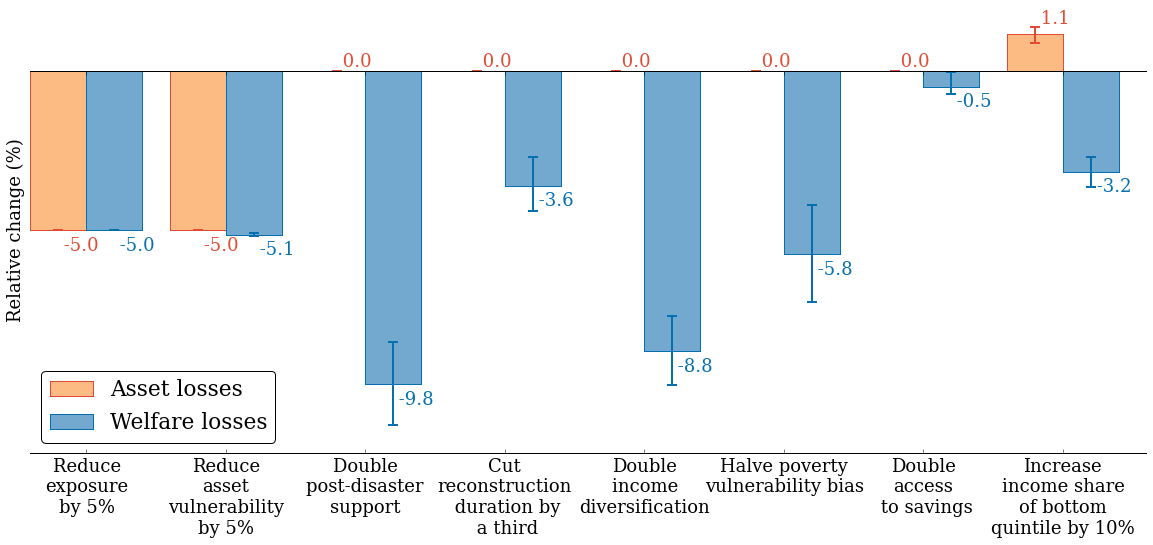

In [97]:
plot_sensiv(sensiv)
plt.savefig("mumbai_sensiv.png",bbox_inches="tight")

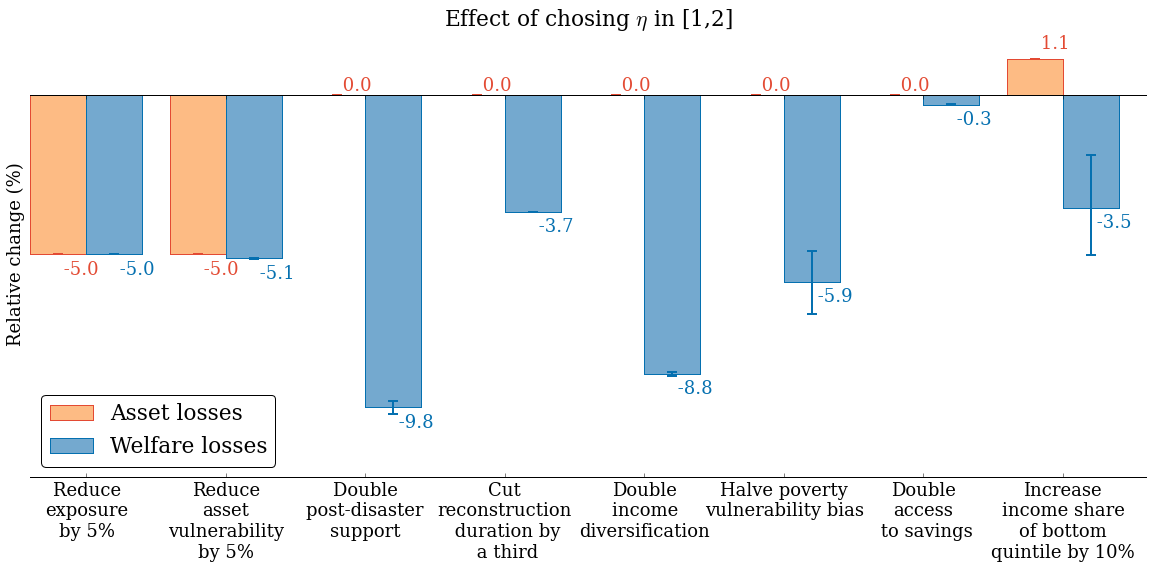

In [98]:
plot_sensiv(sensiv_eta)
plt.title("Effect of chosing $\eta$ in [1,2]")
plt.savefig("mumbai_sensiv_eta.png",bbox_inches="tight")

###Scatter plot to compare policies

In [99]:
mins = sensiv.min().min()
maxs = sensiv.max().max()
cent = .5*(maxs+mins)

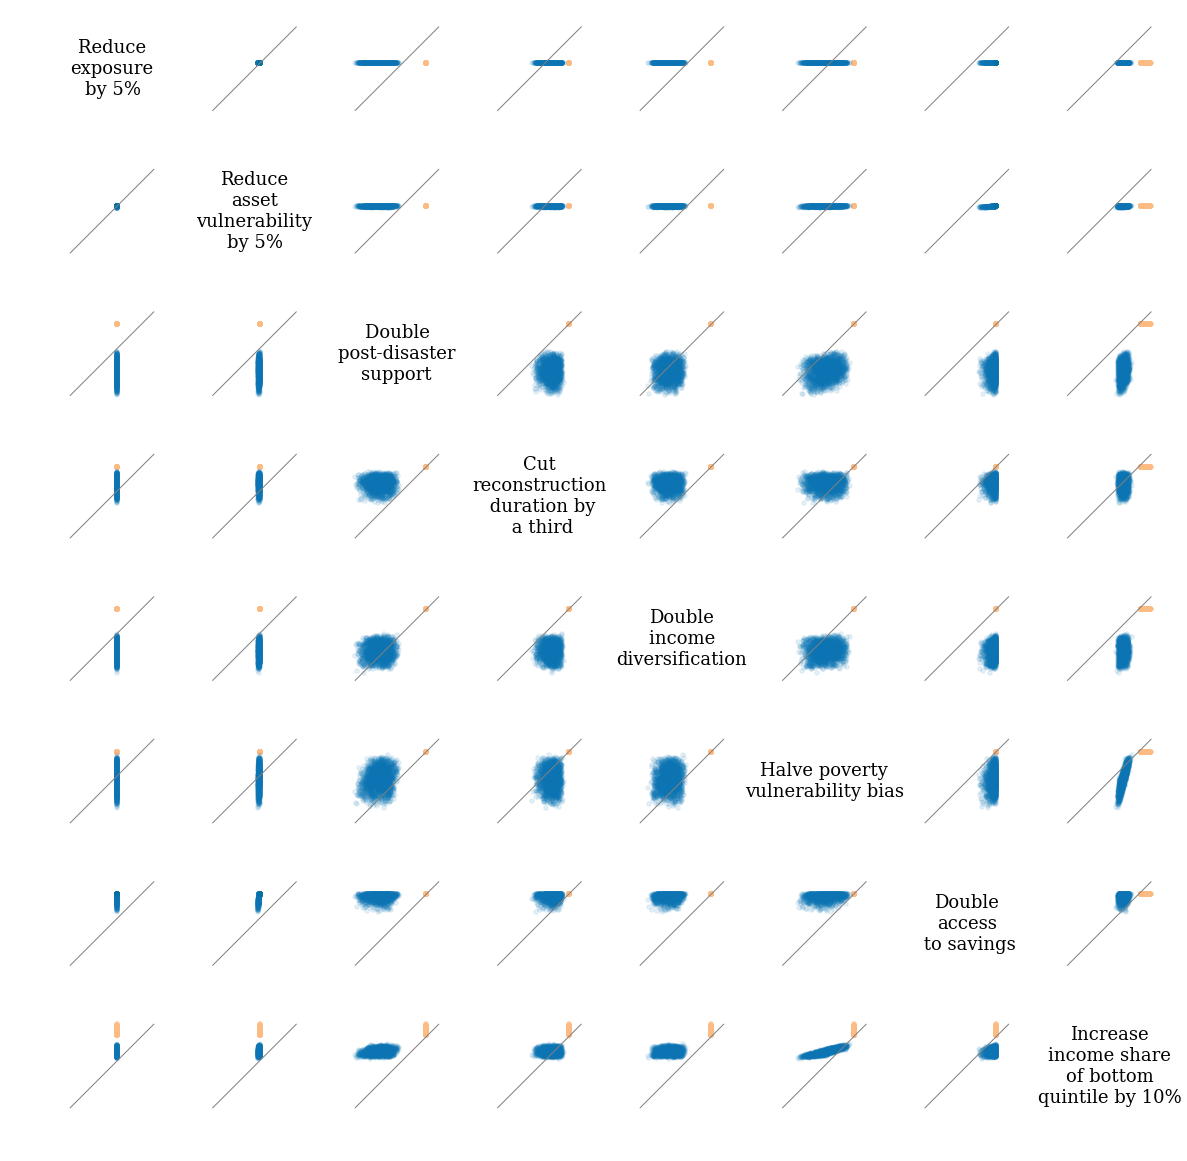

In [100]:
pols =['fa_.95', 'v_.95', 'double_sigma','rebuild_one_third','double_social',
       'halve_pv', 'double_banks', 'share1_ten_percent']

p=len(pols)
fig,axes = plt.subplots(p,p,figsize=(20,20),sharex=True,sharey=True)
for i in range(p):
    for j in range(p):   
        axes[i,j].axis("off")
        
        if i==j:
            axes[i,j].text(cent,cent, policy_descriptions[pols[i]],ha="center",va="center")
        else:
            #mind the trick here, axes is indexed as [line, column] while plots are drawn (x,y)
            axes[i,j].plot([mins,maxs],[mins,maxs],color="gray")
            axes[i,j].scatter(
                sensiv.xs("dKtot", axis=1, level="metric")[pols[j]],
                sensiv.xs("dKtot", axis=1, level="metric")[pols[i]],
                color =col_a, alpha=0.75,clip_on=False
            );
            axes[i,j].scatter(
                sensiv.xs("total_equivalent_cost", axis=1, level="metric")[pols[j]],
                sensiv.xs("total_equivalent_cost", axis=1, level="metric")[pols[i]],
                color=col_d,alpha=0.10,clip_on=False
            );
            
fig.savefig("scatter_policies_mumbai.png",bbox_inches="tight")                                          

# Simple OLS

In [101]:
from statsmodels.formula.api import ols

In [102]:
explicative_set = ['avg_prod_k', 'axfin_p', 'axfin_r', 'axhealth', 'fa', 'finance_pre', 'gdp_pc_pp', 
                   'pe', 'plgp', 'prepare_scaleup', 'protection', 'pv', 'rating', 'share1',
                   'shew', 'social_p', 'social_r', 'unemp', 'v']

formula ="resilience ~ "+" + ".join(explicative_set) 
olsmodel=ols(formula,data=df_with_results).fit()

a=olsmodel.summary()
f = open('regression_against_intpus.csv', 'w')
f.write(a.as_csv())
f.close()
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             resilience   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     41.30
Date:                Tue, 21 Jul 2015   Prob (F-statistic):           1.92e-30
Time:                        17:46:30   Log-Likelihood:                 162.43
No. Observations:                  90   AIC:                            -286.9
Df Residuals:                      71   BIC:                            -239.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.4212      0.056      7.511      0.000         0.309     0.533
avg_prod_k         -0.4145      0.046     -8.953      0.000        -0.507    -0.322
axfin_p            -0.0309      0.104     -0.299      0.766        -0.237     0.176
axfin_r             0.0648      0.083      0.784      0.435        -0.100     0.230
axhealth           -0.0750      0.055     -1.369      0.175        -0.184     0.034
fa                  0.0117      0.101      0.115      0.909        -0.190     0.213
finance_pre         0.0195      0.050      0.390      0.698        -0.080     0.119
gdp_pc_pp         -1.2e-06   1.34e-06     -0.894      0.374     -3.88e-06  1.48e-06
pe                  0.0842      0.011      7.511      0.000         0.062     0.107
plgp                0.1145      0.045      2.550      0.013         0.025     0.204
prepare_scaleup     0.0614      0.049      1.251      0.215        -0.036     0.159
protection          0.0001      0.000      0.336      0.738        -0.001     0.001
pv                 -0.0485      0.008     -6.250      0.000        -0.064    -0.033
rating              0.0372      0.032      1.176      0.244        -0.026     0.100
share1              2.3150      0.351      6.588      0.000         1.614     3.016
shew               -0.0191      0.042     -0.453      0.652        -0.103     0.065
social_p            0.1850      0.037      5.044      0.000         0.112     0.258
social_r            0.1140      0.059      1.926      0.058        -0.004     0.232
unemp               0.0536      0.100      0.534      0.595        -0.147     0.254
v                  -0.0026      0.044     -0.060      0.952        -0.090     0.084
==============================================================================
Omnibus:                       16.997   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.754
Skew:                           0.881   Prob(JB):                     1.15e-05
Kurtosis:                       4.721   Cond. No.                     5.11e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [103]:
b=olsmodel.params[olsmodel.pvalues<15e-2]
b=b.reset_index()
b["desc"]=b["index"].replace(pd.read_csv("inputs_info.csv",usecols=["key","descriptor"],index_col="key",squeeze=True))
b.set_index("desc")[0].to_csv("main_ols.csv")

In [104]:
b.sort(columns=0)

,index,0,desc
1,avg_prod_k,-0.414473894,Productivity of capital
4,pv,-0.048505979,Asset-vulnerability bias
2,pe,0.084241070,Exposure bias
7,social_r,0.114028044,Social protection for non-poor people
3,plgp,0.114494641,Basic education
6,social_p,0.185043661,Social protection for poor people
0,Intercept,0.421205351,Intercept
5,share1,2.315034795,Income share of bottom quintile


In [105]:
b

,index,0,desc
0,Intercept,0.421205351,Intercept
1,avg_prod_k,-0.414473894,Productivity of capital
2,pe,0.084241070,Exposure bias
3,plgp,0.114494641,Basic education
4,pv,-0.048505979,Asset-vulnerability bias
5,share1,2.315034795,Income share of bottom quintile
6,social_p,0.185043661,Social protection for poor people
7,social_r,0.114028044,Social protection for non-poor people
